### Versão Rodrigo

In [2]:
import warnings
import numpy as np
from tqdm import tqdm

# Para evitar warning de divisão por zero
warnings.simplefilter(action='ignore')

def NLM(img, h, f, t):

    
    # Dimenssões espaciais da imagem
    m, n = img.shape

    # Cria imagem de saída
    filtrada = np.zeros((m, n))

    # Problema de valor de contorno: replicar bordas
    #img_n = np.pad(ruidosa, ((f, f), (f, f)), 'symmetric') # Modifiquei esta linha
    img_n = np.pad(img, ((f, f), (f, f)), 'symmetric')


    # Initializing the counter
    prog = tqdm(total=m*n, position=0, leave=True)

    # Loop principal do NLM
    for i in range(m):
        for j in range(n):

            im = i + f;   # compensar a borda adicionada artificialmente
            jn = j + f;   # compensar a borda adicionada artificialmente

            # Obtém o patch ao redor do pixel corrente
            W1 = img_n[im-f:(im+f)+1, jn-f:(jn+f)+1]

            # Calcula as bordas da janela de busca para o pixel corrente (se pixel próximo das bordas, janela de busca é menor)
            rmin = max(im-t, f);  # linha inicial
            rmax = min(im+t, m+f);  # linha final
            smin = max(jn-t, f);  # coluna inicial
            smax = min(jn+t, n+f);  # coluna final

            # Calcula média ponderada
            NL = 0      # valor do pixel corrente filtrado
            Z = 0       # constante normalizadora

            # Loop para todos os pixels da janela de busca
            for r in range(rmin, rmax):
                for s in range(smin, smax):

                    # Obtém o patch ao redor do pixel a ser comparado
                    W2 = img_n[r-f:(r+f)+1, s-f:(s+f)+1]

                    # Calcula o quadrado da distância Euclidiana
                    d2 = np.sum((W1 - W2)*(W1 - W2))

                    # Calcula a medida de similaridade
                    sij = np.exp(-d2/(h**2))

                    # Atualiza Z e NL
                    Z = Z + sij
                    NL = NL + sij*img_n[r, s]

            # Normalização do pixel filtrado
            filtrada[i, j] = NL/Z
            prog.update(1)
    return filtrada

In [ ]:
import cv2
img = cv2.imread("images/Lenna_ruidosa.png", cv2.IMREAD_GRAYSCALE)

filtrada = NLM(img,1,3,10)

### NLM versão ChatGpt

In [ ]:
import cv2
import numpy as np

def non_local_means_denoising(image, h=10, patch_size=5, search_size=17):
    """
    Implementação do Non-Local Means (NLM) para remoção de ruído.
    :param image: Imagem de entrada (numpy array, escala de cinza).
    :param h: Fator de filtragem (maior valor remove mais ruído, mas pode borrar a imagem).
    :param patch_size: Tamanho do patch (área considerada para similaridade local).
    :param search_size: Tamanho da área de busca ao redor de cada pixel.
    :return: Imagem filtrada.
    """
    
    # Converte para float para evitar problemas de precisão
    image = image.astype(np.float32)
    
    # Dimensões da imagem
    rows, cols = image.shape
    
    # Define metade dos tamanhos
    half_patch = patch_size // 2
    half_search = search_size // 2
    
    # Resultado final
    filtered_image = np.zeros_like(image)
    
    # Pad para lidar com bordas
    padded_image = cv2.copyMakeBorder(image, half_search, half_search, half_search, half_search, cv2.BORDER_REFLECT)
    
    for i in range(rows):
        for j in range(cols):
            i_p = i + half_search
            j_p = j + half_search
            
            # Extrai o patch central
            patch_center = padded_image[i_p - half_patch:i_p + half_patch + 1, j_p - half_patch:j_p + half_patch + 1]
            
            weights = []
            values = []
            
            # Percorre a janela de busca
            for m in range(-half_search, half_search + 1):
                for n in range(-half_search, half_search + 1):
                    
                    if m == 0 and n == 0:
                        continue
                    
                    # Extrai o patch vizinho
                    patch_neighbor = padded_image[i_p + m - half_patch:i_p + m + half_patch + 1, j_p + n - half_patch:j_p + n + half_patch + 1]
                    
                    # Calcula a distância Euclidiana entre os patches
                    dist = np.sum((patch_center - patch_neighbor) ** 2)
                    weight = np.exp(-dist / (h ** 2))
                    
                    weights.append(weight)
                    values.append(padded_image[i_p + m, j_p + n])
            
            # Normaliza os pesos
            weights = np.array(weights)
            weights /= np.sum(weights)
            
            # Aplica os pesos aos valores e atribui ao pixel filtrado
            filtered_image[i, j] = np.sum(weights * np.array(values))
    
    return np.clip(filtered_image, 0, 255).astype(np.uint8)

# Exemplo de uso
if __name__ == "__main__":
    img = cv2.imread("ruidosa/ruidosa_salt_pepper.png", cv2.IMREAD_GRAYSCALE)
    denoised_img = non_local_means_denoising(img, h=10, patch_size=3, search_size=17)
    cv2.imwrite("imagem_denoised.jpg", denoised_img)
    cv2.imshow("Denoised Image", denoised_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [1]:
from skimage import img_as_float
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

def non_local_means(image, patch_size=5, search_size=17, h=10):
    """
    Aplica o algoritmo Non-Local Means para remoção de ruído.
    - image: imagem de entrada (numpy array).
    - patch_size: tamanho do patch local (pequena vizinhança).
    - search_size: tamanho da área de busca para encontrar pixels semelhantes.
    - h: parâmetro de suavização (quanto maior, mais agressivo o filtro).
    """
    image = img_as_float(image)  # Normalizar para [0,1]
    filtered_image = np.zeros_like(image)
    pad_size = search_size // 2  # Padding para bordas
    padded_image = np.pad(image, pad_size, mode='reflect')

    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            i_p = i + pad_size
            j_p = j + pad_size
            
            patch = padded_image[i_p - patch_size//2 : i_p + patch_size//2 + 1, 
                                 j_p - patch_size//2 : j_p + patch_size//2 + 1]
            
            # Janela de busca
            search_window = padded_image[i_p - pad_size : i_p + pad_size + 1, 
                                         j_p - pad_size : j_p + pad_size + 1]

            # Computar pesos
            weights = np.zeros_like(search_window)
            for m in range(search_window.shape[0] - patch_size + 1):
                for n in range(search_window.shape[1] - patch_size + 1):
                    neighbor_patch = search_window[m:m+patch_size, n:n+patch_size]
                    distance = np.sum((patch - neighbor_patch) ** 2)
                    weights[m, n] = np.exp(-distance / (h ** 2))

            # Normalizar pesos e calcular pixel filtrado
            weights /= np.sum(weights)
            filtered_pixel = np.sum(weights * search_window)
            filtered_image[i, j] = filtered_pixel

    return filtered_image

# Criar imagem com ruído para teste
image = np.zeros((256, 256))
image[25:75, 25:75] = 1  # Quadrado branco
noisy_image = random_noise(image, var=0.02)  # Adicionar ruído

# Aplicar filtro
filtered_image = non_local_means(noisy_image)

# Exibir imagens
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(noisy_image, cmap="gray")
axs[0].set_title("Imagem com Ruído")
axs[0].axis("off")

axs[1].imshow(filtered_image, cmap="gray")
axs[1].set_title("Imagem Filtrada (NLM)")
axs[1].axis("off")

plt.show()


KeyboardInterrupt: 

### Tentando rodar o NLM Geodésico em toda a imagem - TRAVA

In [15]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise

def load_image(path, add_noise=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if add_noise:
        img = random_noise(img, mode='s&p', amount=0.05)  # Adiciona ruído sal e pimenta
        img = (img * 255).astype(np.uint8)
    return img

def build_graph(image, center, patch_size=21):
    half = patch_size // 2
    x0, y0 = center
    H, W = image.shape
    G = nx.Graph()
    
    for i in range(max(0, x0 - half), min(H, x0 + half + 1)):
        for j in range(max(0, y0 - half), min(W, y0 + half + 1)):
            G.add_node((i, j), intensity=image[i, j])
            
            for di, dj in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                ni, nj = i + di, j + dj
                if (max(0, x0 - half) <= ni < min(H, x0 + half + 1)) and (max(0, y0 - half) <= nj < min(W, y0 + half + 1)):
                    weight = np.abs(int(image[i, j]) - int(image[ni, nj])) + 1e-5
                    G.add_edge((i, j), (ni, nj), weight=weight)
    return G

def compute_geodesic_distance(G, center):
    return nx.single_source_dijkstra_path_length(G, source=center, weight='weight')

def apply_nlm_geodesic(image, patch_size=21, h=10):
    H, W = image.shape
    output = np.zeros_like(image, dtype=np.float32)
    
    for i in range(H):
        for j in range(W):
            G = build_graph(image, (i, j), patch_size)
            distances = compute_geodesic_distance(G, (i, j))
            
            weights = np.exp(-np.array(list(distances.values())) / (h**2))
            total_weight = np.sum(weights)
            
            if total_weight > 0:
                output[i, j] = np.sum(weights * np.array([image[n] for n in distances.keys()])) / total_weight
            else:
                output[i, j] = image[i, j]
    
    return output.astype(np.uint8)

def visualize_graph(image, center, patch_size):
    G = build_graph(image, center, patch_size)
    pos = {node: (node[1], node[0]) for node in G.nodes()}
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    nx.draw(G, pos, node_size=30, edge_color='gray', alpha=0.3, with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[center], node_color='red', node_size=100)
    plt.title(f"Grafo e Caminhos para o Pixel Central {center}")
    plt.show()

# Carregar imagem
image_path = 'ruidosa/ruidosa_salt_pepper.png'
image = load_image(image_path)

# Aplicar filtragem usando distância geodésica
filtered_image = apply_nlm_geodesic(image)

# Visualizar grafo e caminhos
pixel_central = (100, 100)
visualize_graph(image, pixel_central, patch_size=21)

# Mostrar imagens
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Imagem com Ruído")
ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title("Imagem Filtrada (Geodésico NLM)")
plt.show()

KeyboardInterrupt: 

### Exibição com todos os pixels ligados ao central utilizando o Djkstra para calcular os caminhos mínimos.

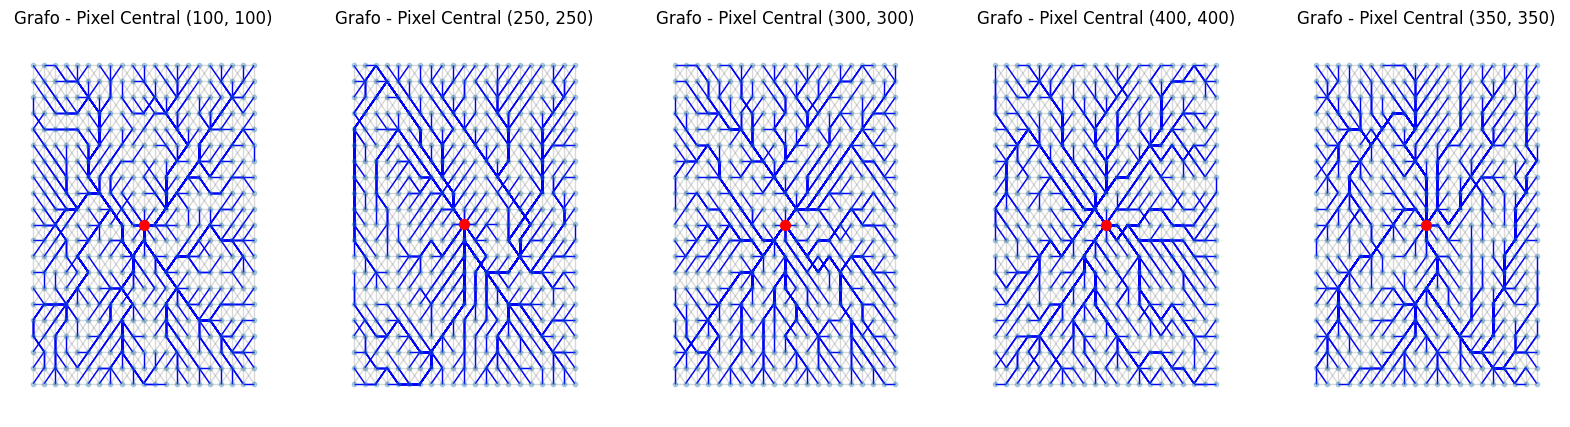

In [10]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise

def load_image(path, add_noise=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if add_noise:
        img = random_noise(img, mode='s&p', amount=0.05)  # Adiciona ruído sal e pimenta
        img = (img * 255).astype(np.uint8)
    return img

def build_graph(image, center, patch_size=21):
    half = patch_size // 2
    x0, y0 = center
    H, W = image.shape
    G = nx.Graph()
    
    for i in range(max(0, x0 - half), min(H, x0 + half + 1)):
        for j in range(max(0, y0 - half), min(W, y0 + half + 1)):
            G.add_node((i, j), intensity=image[i, j])
            
            for di, dj in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                ni, nj = i + di, j + dj
                if (max(0, x0 - half) <= ni < min(H, x0 + half + 1)) and (max(0, y0 - half) <= nj < min(W, y0 + half + 1)):
                    weight = np.abs(int(image[i, j]) - int(image[ni, nj])) + 1e-5
                    G.add_edge((i, j), (ni, nj), weight=weight)
    return G

def visualize_graphs(centers, image, patch_size):
    fig, axes = plt.subplots(1, len(centers), figsize=(20, 5))
    
    for ax, center in zip(axes, centers):
        G = build_graph(image, center, patch_size)
        pos = {node: (node[1], node[0]) for node in G.nodes()}
        
        # Calcular caminhos geodésicos do centro para todos os outros nós
        shortest_paths = nx.single_source_dijkstra_path(G, center)
        
        ax.set_title(f"Grafo - Pixel Central {center}")
        nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.3, with_labels=False, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[center], node_color='red', node_size=50, ax=ax)
        
        for target in shortest_paths.keys():
            path_edges = list(zip(shortest_paths[target], shortest_paths[target][1:]))
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='blue', width=1, ax=ax)
        
        ax.axis("off")  # Remover eixos
    
    plt.show()

# Carregar imagem
image_path = 'ruidosa/ruidosa_salt_pepper.png'
image = load_image(image_path)

# Definir os pixels centrais
centers = [(100, 100), (250, 250), (300, 300), (400, 400), (350, 350)]
visualize_graphs(centers, image, patch_size=21)


### Exibição dos lugares dos patches

C:\Users\adria\AppData\Local\Temp\ipykernel_21128\663087555.py:26: RuntimeWarning: overflow encountered in scalar subtract
  if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário


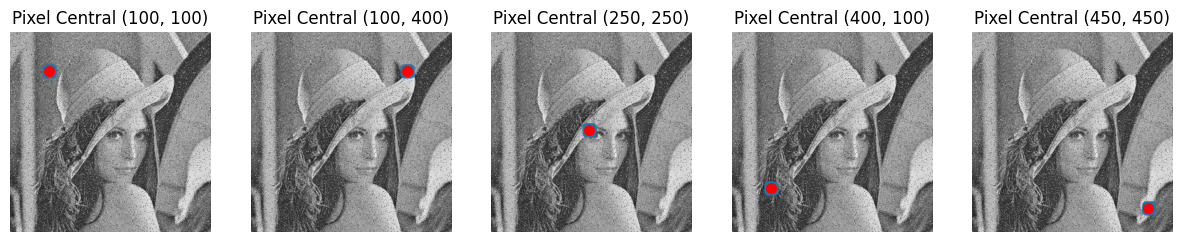

In [1]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise

def load_image(path, add_noise=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if add_noise:
        img = random_noise(img, mode='s&p', amount=0.05)  # Adiciona ruído sal e pimenta
        img = (img * 255).astype(np.uint8)
    return img

def build_graph(image, center, patch_size=21, similarity_patch=5):
    half = patch_size // 2
    half_similarity = similarity_patch // 2
    x0, y0 = center
    H, W = image.shape
    G = nx.Graph()
    
    for i in range(max(0, x0 - half), min(H, x0 + half + 1)):
        for j in range(max(0, y0 - half), min(W, y0 + half + 1)):
            G.add_node((i, j), intensity=image[i, j])
            
            # Conectar apenas pixels similares ao central dentro do patch de similaridade
            if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário
                for di in range(-half_similarity, half_similarity + 1):
                    for dj in range(-half_similarity, half_similarity + 1):
                        ni, nj = i + di, j + dj
                        if (max(0, x0 - half) <= ni < min(H, x0 + half + 1)) and (max(0, y0 - half) <= nj < min(W, y0 + half + 1)):
                            weight = np.abs(int(image[i, j]) - int(image[ni, nj])) + 1e-5
                            G.add_edge((i, j), (ni, nj), weight=weight)
    return G

def visualize_graph_with_paths(image, centers, patch_size, similarity_patch):
    fig, axes = plt.subplots(1, len(centers), figsize=(15, 5))
    
    for ax, center in zip(axes, centers):
        G = build_graph(image, center, patch_size, similarity_patch)
        pos = {node: (node[1], node[0]) for node in G.nodes()}
        
        # Calcular caminhos geodésicos do centro apenas para pixels similares
        shortest_paths = nx.single_source_dijkstra_path(G, center)
        
        ax.imshow(image, cmap='gray')
        nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.3, with_labels=False, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[center], node_color='red', node_size=50, ax=ax)
        
        for target in shortest_paths.keys():
            path_edges = list(zip(shortest_paths[target], shortest_paths[target][1:]))
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='blue', width=1, ax=ax)
        
        ax.set_title(f"Pixel Central {center}")
    
    plt.show()

# Carregar imagem
image_path = 'ruidosa/ruidosa_salt_pepper.png'
image = load_image(image_path)

# Definir pixels centrais para visualização dos grafos
centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]
visualize_graph_with_paths(image, centers, patch_size=21, similarity_patch=5)

### Imagem com ruído

C:\Users\adria\AppData\Local\Temp\ipykernel_21128\2444770903.py:26: RuntimeWarning: overflow encountered in scalar subtract
  if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário


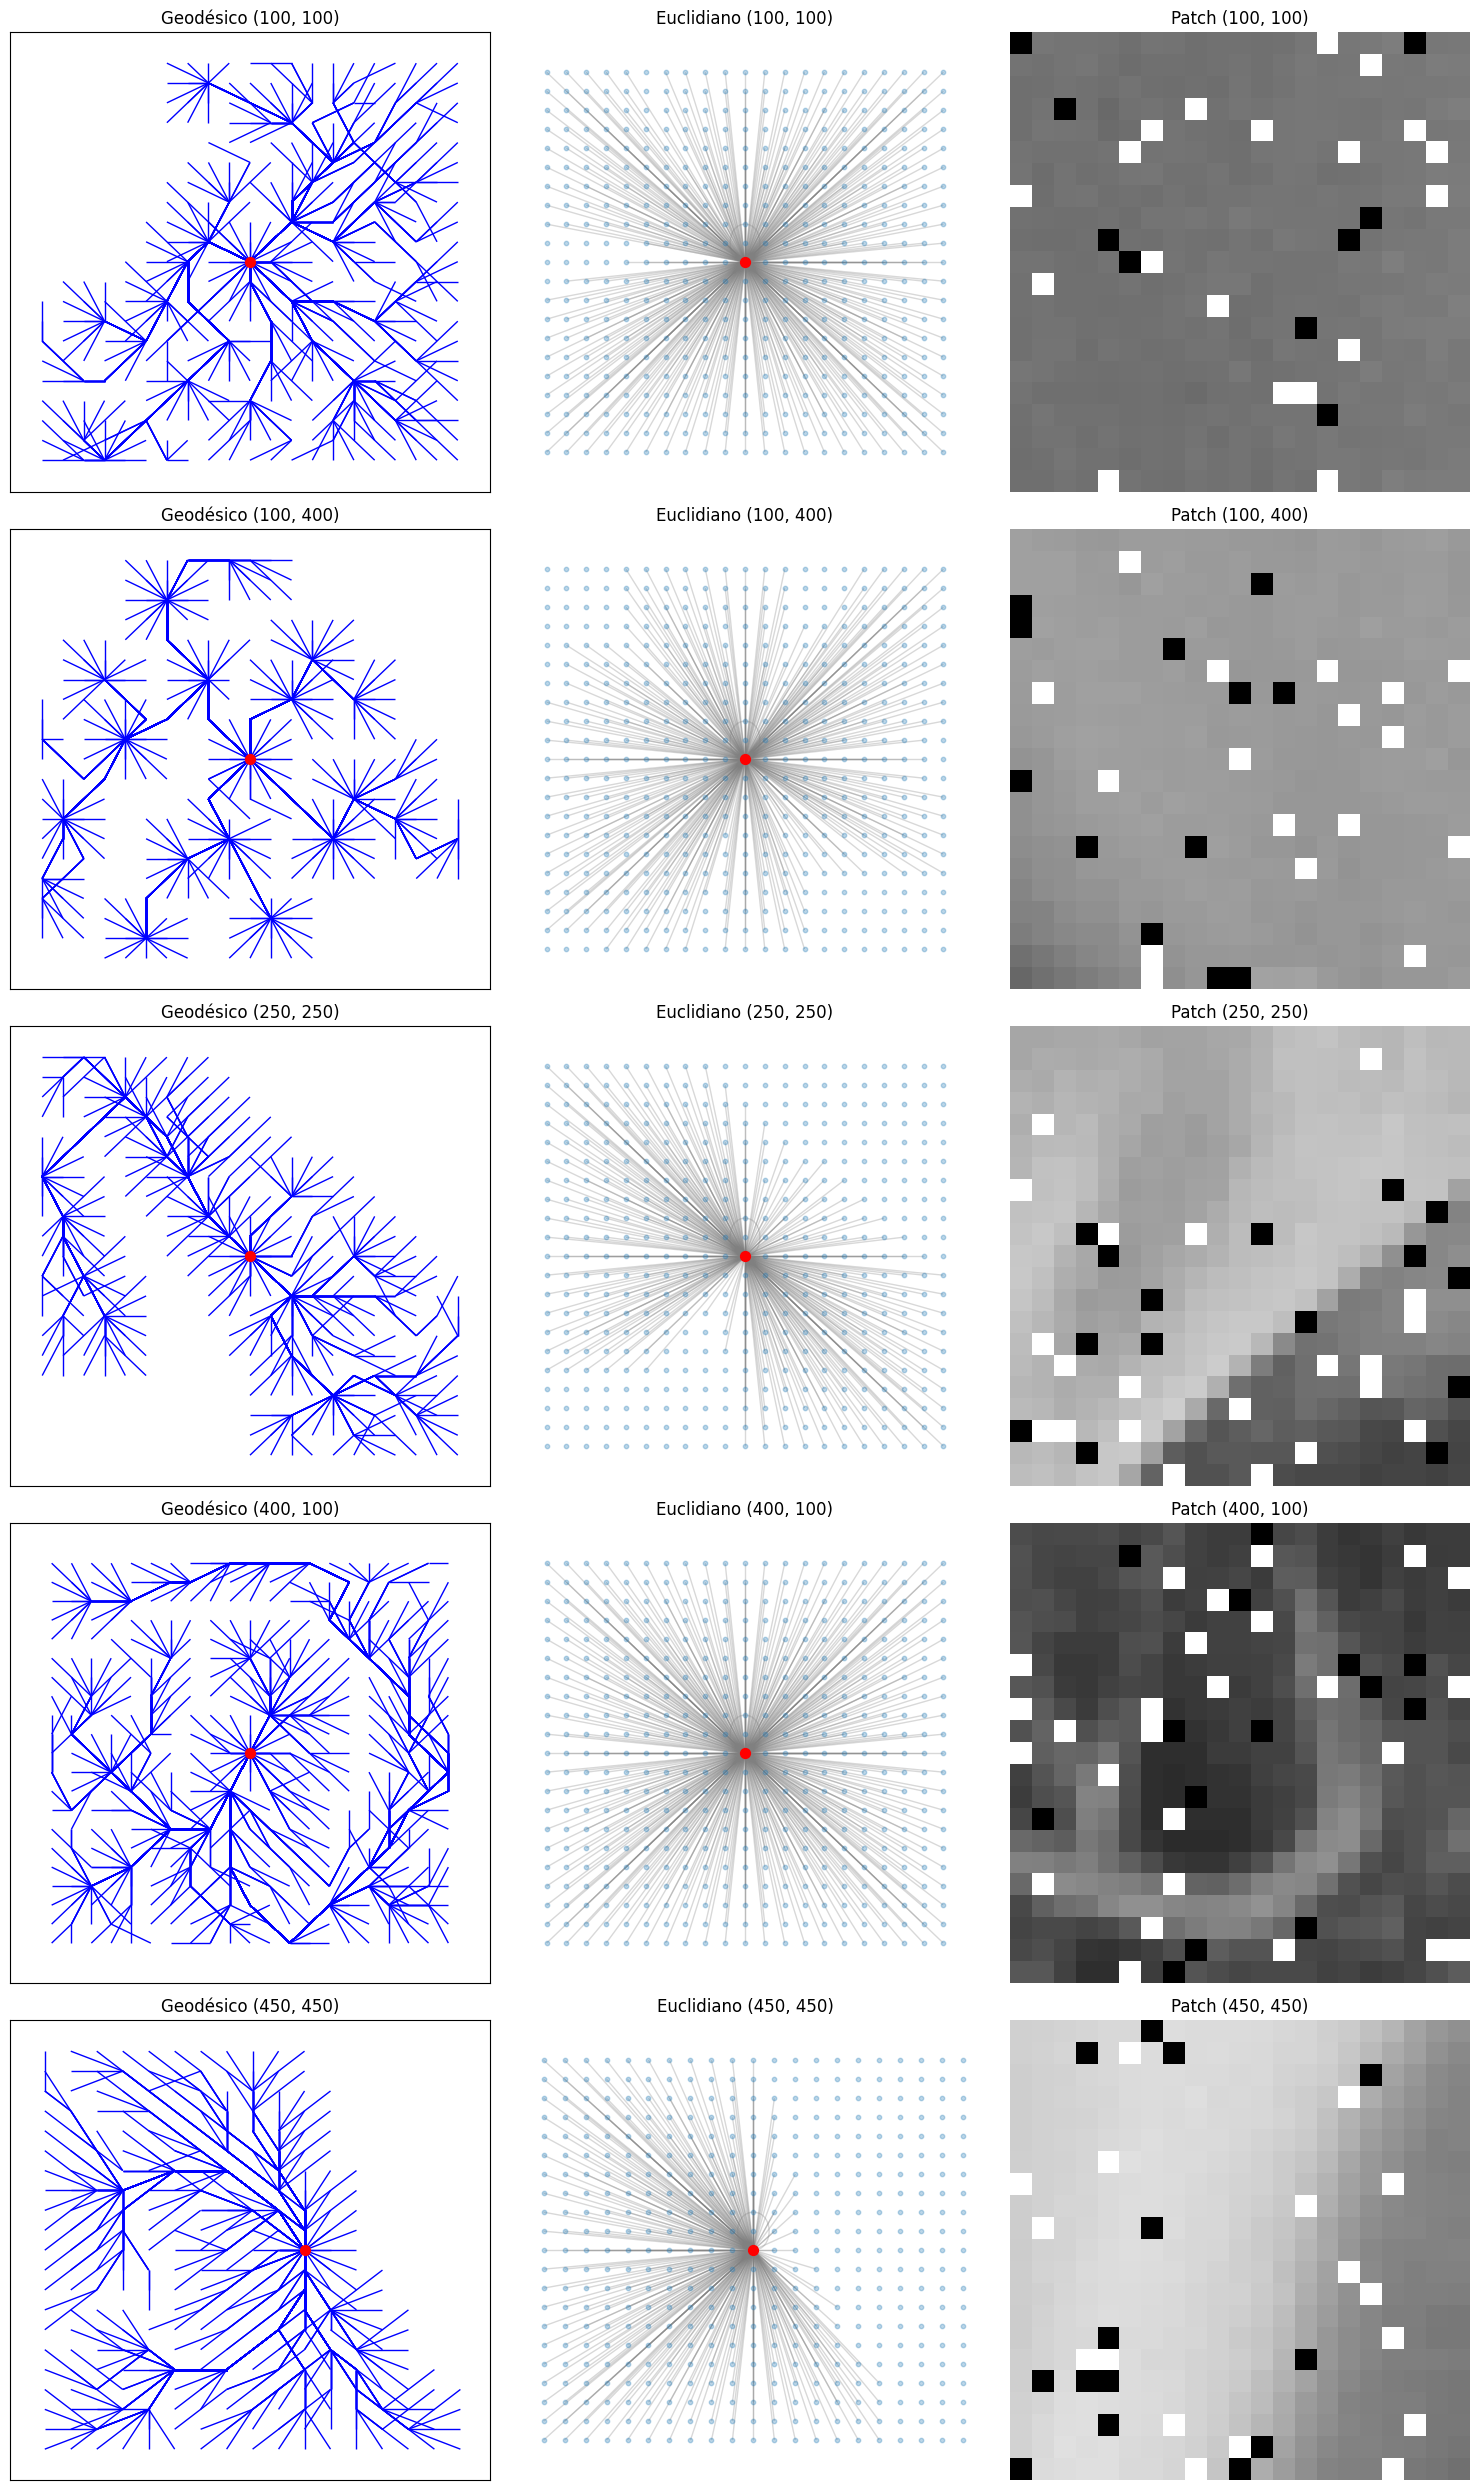

: 

In [ ]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise

def load_image(path, add_noise=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if add_noise:
        img = random_noise(img, mode='s&p', amount=0.05)  # Adiciona ruído sal e pimenta
        img = (img * 255).astype(np.uint8)
    return img

def build_graph(image, center, patch_size=21, similarity_patch=5, euclidean=False):
    half = patch_size // 2
    half_similarity = similarity_patch // 2
    x0, y0 = center
    H, W = image.shape
    G = nx.Graph()
    
    for i in range(max(0, x0 - half), min(H, x0 + half + 1)):
        for j in range(max(0, y0 - half), min(W, y0 + half + 1)):
            G.add_node((i, j), intensity=image[i, j])
            
            # Conectar apenas pixels similares ao central dentro do patch de similaridade
            if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário
                for di in range(-half_similarity, half_similarity + 1):
                    for dj in range(-half_similarity, half_similarity + 1):
                        ni, nj = i + di, j + dj
                        if (max(0, x0 - half) <= ni < min(H, x0 + half + 1)) and (max(0, y0 - half) <= nj < min(W, y0 + half + 1)):
                            weight = np.abs(int(image[i, j]) - int(image[ni, nj])) + 1e-5
                            if euclidean:
                                G.add_edge((x0, y0), (ni, nj), weight=weight)  # Ligação direta ao pixel central
                            else:
                                G.add_edge((i, j), (ni, nj), weight=weight)  # Caminho geodésico
    return G

def visualize_graphs(centers, patch_size, similarity_patch):
    fig, axes = plt.subplots(len(centers), 3, figsize=(15, 5 * len(centers)))
    
    for idx, center in enumerate(centers):
        G_geo = build_graph(image, center, patch_size, similarity_patch, euclidean=False)
        G_euc = build_graph(image, center, patch_size, similarity_patch, euclidean=True)
        
        pos_geo = {node: (node[1], node[0]) for node in G_geo.nodes()}
        pos_euc = {node: (node[1], node[0]) for node in G_euc.nodes()}
        
        # Calcular caminhos geodésicos do centro apenas para pixels similares
        shortest_paths = nx.single_source_dijkstra_path(G_geo, center)
        
        ax_geo, ax_euc, ax_patch = axes[idx]
        nx.draw_networkx_nodes(G_geo, pos_geo, nodelist=[center], node_color='red', node_size=50, ax=ax_geo)
        for target in shortest_paths.keys():
            path_edges = list(zip(shortest_paths[target], shortest_paths[target][1:]))
            nx.draw_networkx_edges(G_geo, pos_geo, edgelist=path_edges, edge_color='blue', width=1, ax=ax_geo)
        ax_geo.set_title(f"Geodésico {center}")
        
        nx.draw(G_euc, pos_euc, node_size=10, edge_color='gray', alpha=0.3, with_labels=False, ax=ax_euc)
        nx.draw_networkx_nodes(G_euc, pos_euc, nodelist=[center], node_color='red', node_size=50, ax=ax_euc)
        ax_euc.set_title(f"Euclidiano {center}")
        
        # Exibir a fatia da imagem
        half = patch_size // 2
        patch = image[center[0] - half:center[0] + half + 1, center[1] - half:center[1] + half + 1]
        ax_patch.imshow(patch, cmap='gray')
        ax_patch.set_title(f"Patch {center}")
        ax_patch.axis("off")
    
    plt.tight_layout()
    plt.show()

# Carregar imagem
image_path = 'ruidosa/ruidosa_salt_pepper.png'
image = load_image(image_path)

# Definir pixels centrais para visualização dos grafos
centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]
visualize_graphs(centers, patch_size=21, similarity_patch=5)


### Imagem sem ruído

C:\Users\adria\AppData\Local\Temp\ipykernel_22520\3240733053.py:33: RuntimeWarning: overflow encountered in scalar subtract
  if abs(image[ni, nj] - image[x0, y0]) < 30:
C:\Users\adria\AppData\Local\Temp\ipykernel_22520\3240733053.py:24: RuntimeWarning: overflow encountered in scalar subtract
  if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário


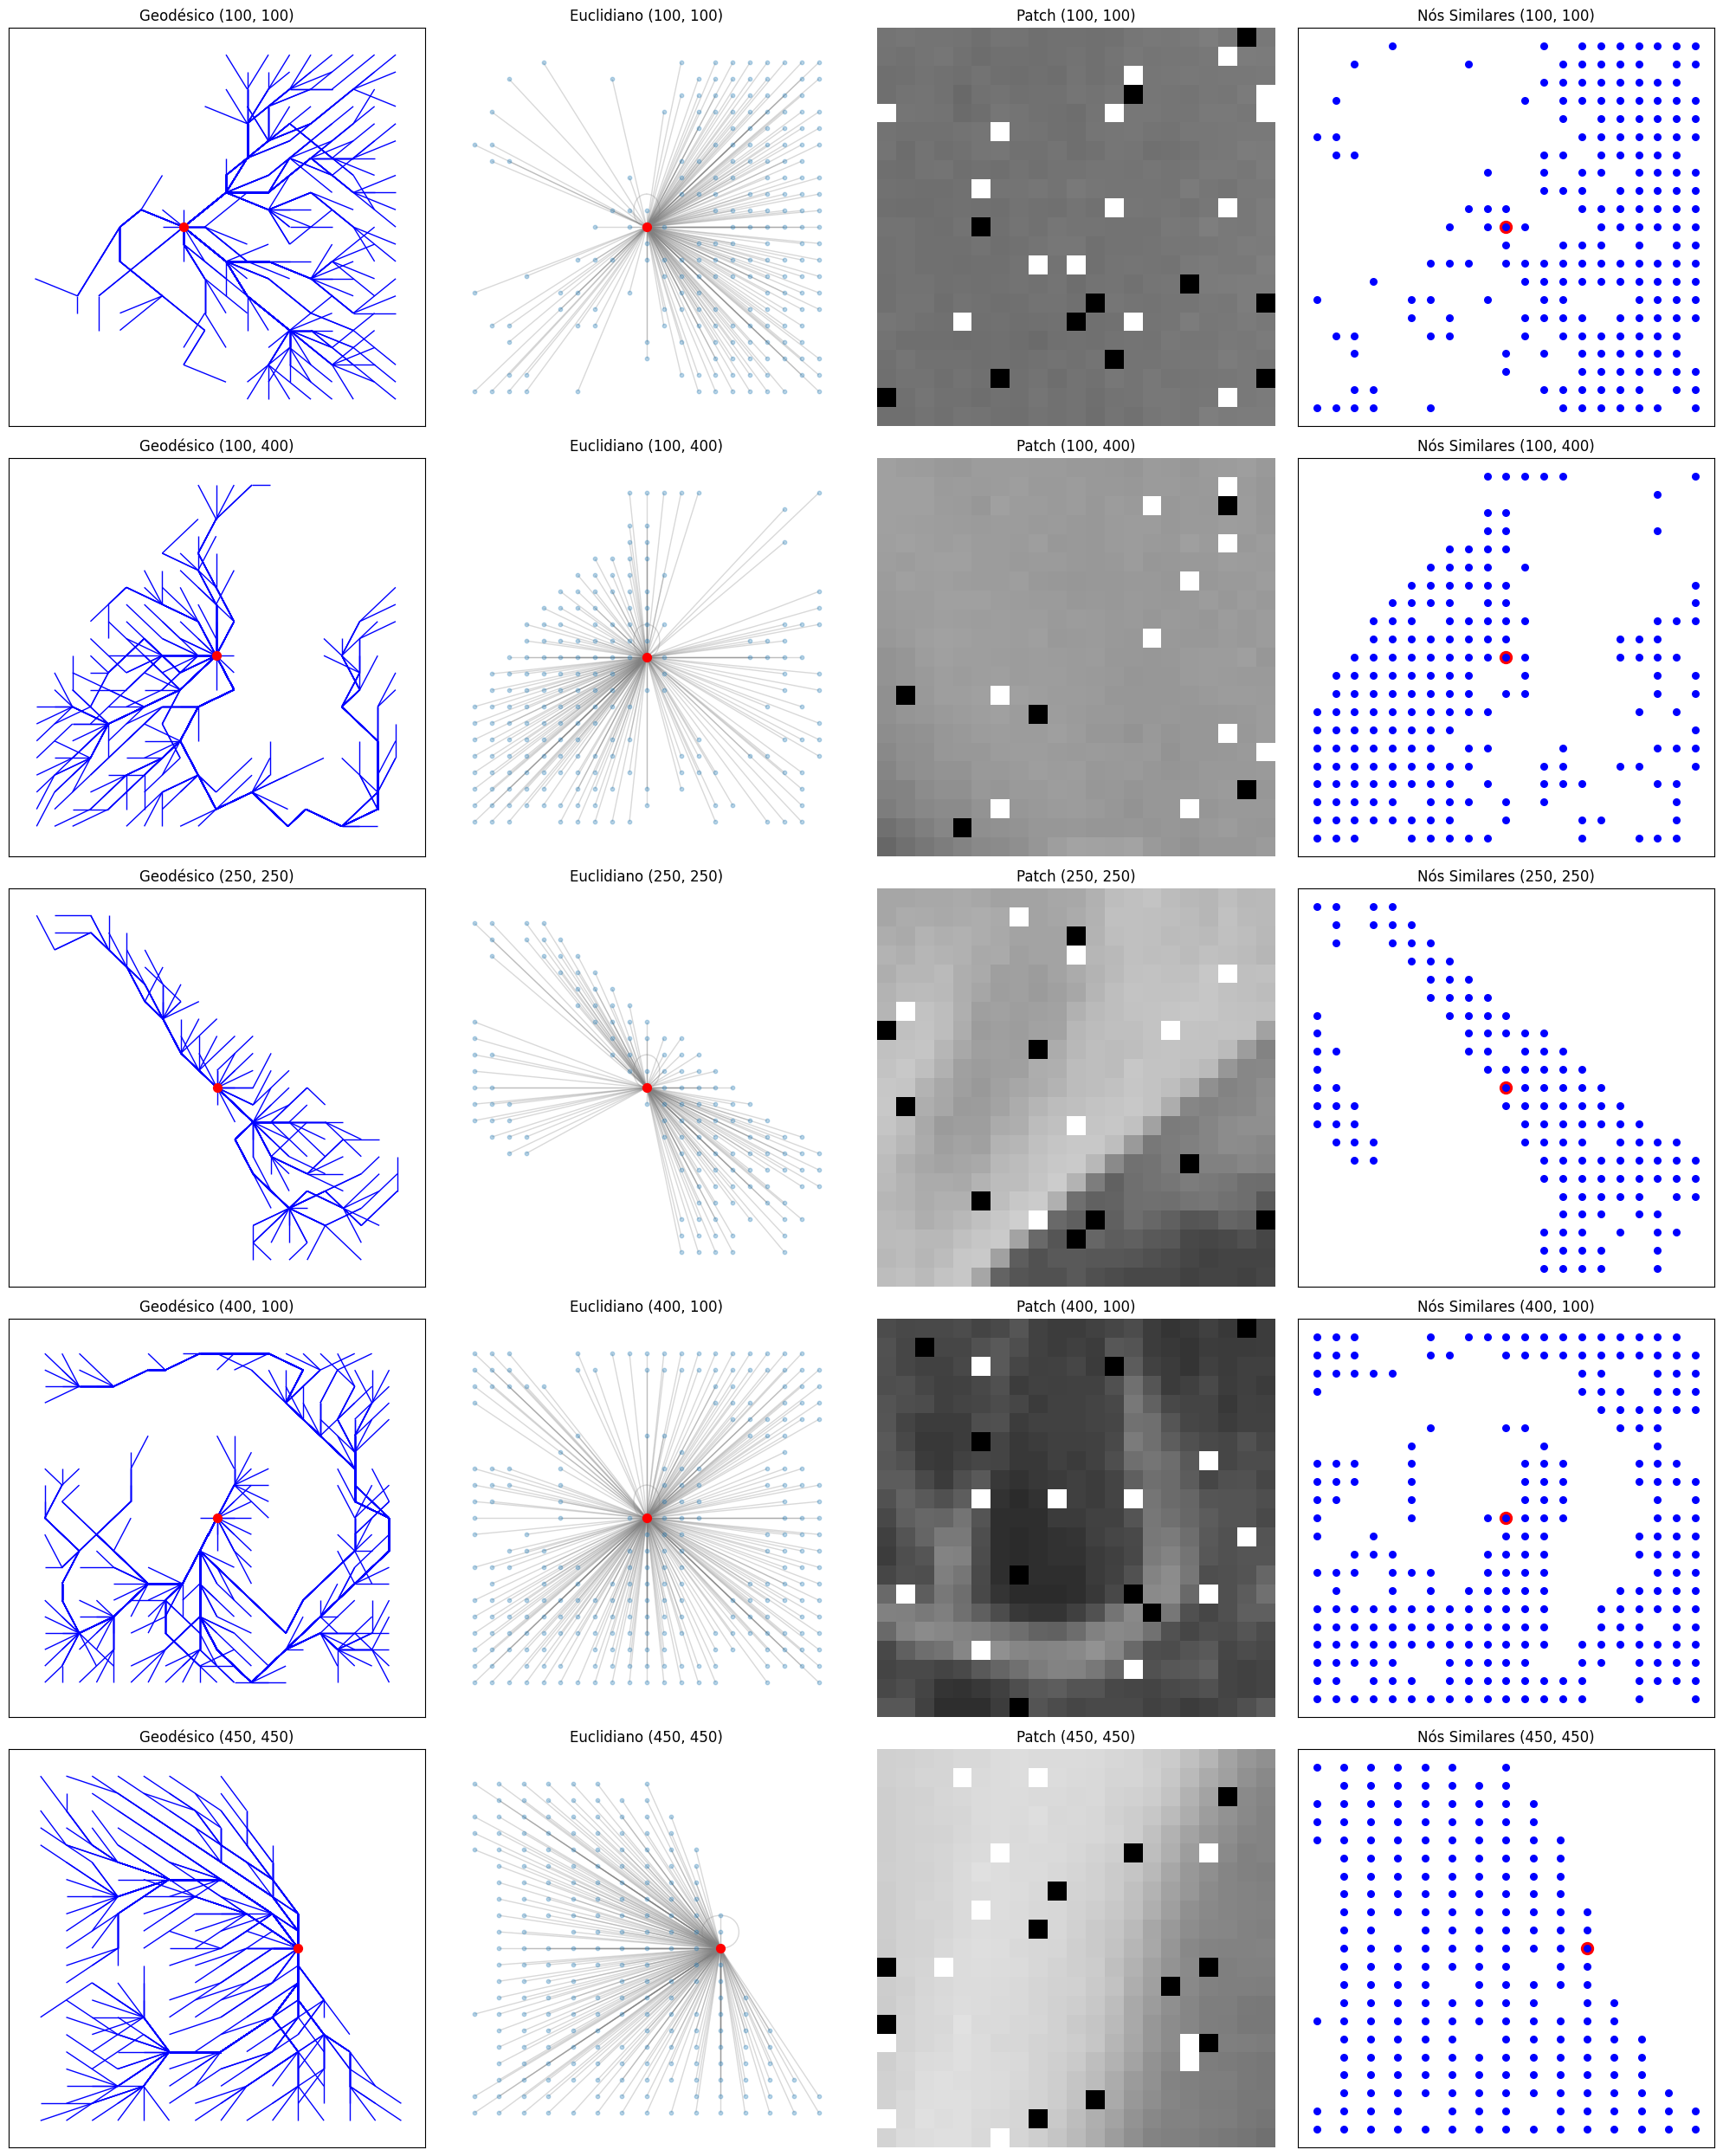

In [22]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise

def load_image(path, add_noise=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if add_noise:
        img = random_noise(img, mode='s&p', amount=0.05)  # Adiciona ruído sal e pimenta
        img = (img * 255).astype(np.uint8)
    return img

def build_graph(image, center, patch_size=21, similarity_patch=5, euclidean=False, only_similar=False):
    half = patch_size // 2
    half_similarity = similarity_patch // 2
    x0, y0 = center
    H, W = image.shape
    G = nx.Graph()
    
    similar_pixels = []
    for i in range(max(0, x0 - half), min(H, x0 + half + 1)):
        for j in range(max(0, y0 - half), min(W, y0 + half + 1)):
            if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário
                similar_pixels.append((i, j))
                G.add_node((i, j), intensity=image[i, j])
                
                if not only_similar:
                    for di in range(-half_similarity, half_similarity + 1):
                        for dj in range(-half_similarity, half_similarity + 1):
                            ni, nj = i + di, j + dj
                            if (max(0, x0 - half) <= ni < min(H, x0 + half + 1)) and (max(0, y0 - half) <= nj < min(W, y0 + half + 1)):
                                if abs(image[ni, nj] - image[x0, y0]) < 30:
                                    weight = np.abs(int(image[i, j]) - int(image[ni, nj])) + 1e-5
                                    if euclidean:
                                        G.add_edge((x0, y0), (ni, nj), weight=weight)  # Ligação direta ao pixel central
                                    else:
                                        G.add_edge((i, j), (ni, nj), weight=weight)  # Caminho geodésico
    
    return G, similar_pixels

def visualize_graphs(centers, patch_size, similarity_patch):
    fig, axes = plt.subplots(len(centers), 4, figsize=(20, 5 * len(centers)))
    
    for idx, center in enumerate(centers):
        G_geo, _ = build_graph(image, center, patch_size, similarity_patch, euclidean=False, only_similar=False)  # Mantém o grafo original
        G_euc, _ = build_graph(image, center, patch_size, similarity_patch, euclidean=True, only_similar=False)
        G_sim, similar_pixels = build_graph(image, center, patch_size, similarity_patch, euclidean=False, only_similar=True)
        
        pos_geo = {node: (node[1], node[0]) for node in G_geo.nodes()}
        pos_euc = {node: (node[1], node[0]) for node in G_euc.nodes()}
        pos_sim = {node: (node[1], node[0]) for node in G_sim.nodes()}
        
        shortest_paths = nx.single_source_dijkstra_path(G_geo, center)
        
        ax_geo, ax_euc, ax_patch, ax_nodes = axes[idx]
        nx.draw_networkx_nodes(G_geo, pos_geo, nodelist=[center], node_color='red', node_size=50, ax=ax_geo)
        for target in shortest_paths.keys():
            path_edges = list(zip(shortest_paths[target], shortest_paths[target][1:]))
            nx.draw_networkx_edges(G_geo, pos_geo, edgelist=path_edges, edge_color='blue', width=1, ax=ax_geo)
        ax_geo.set_title(f"Geodésico {center}")
        
        nx.draw(G_euc, pos_euc, node_size=10, edge_color='gray', alpha=0.3, with_labels=False, ax=ax_euc)
        nx.draw_networkx_nodes(G_euc, pos_euc, nodelist=[center], node_color='red', node_size=50, ax=ax_euc)
        ax_euc.set_title(f"Euclidiano {center}")
        
        half = patch_size // 2
        patch = image[center[0] - half:center[0] + half + 1, center[1] - half:center[1] + half + 1]
        ax_patch.imshow(patch, cmap='gray')
        ax_patch.set_title(f"Patch {center}")
        ax_patch.axis("off")
        
        # Exibir apenas os nós dos pixels similares
        nx.draw_networkx_nodes(G_sim, pos_sim, nodelist=[center], node_color='red', node_size=100, ax=ax_nodes)
        nx.draw_networkx_nodes(G_sim, pos_sim, nodelist=similar_pixels, node_color='blue', node_size=30, ax=ax_nodes)
        ax_nodes.set_title(f"Nós Similares {center}")
    
    plt.tight_layout()
    plt.show()

# Carregar imagem
image_path = 'Lenna.png'
image = load_image(image_path)

# Definir pixels centrais para visualização dos grafos
centers = [(100, 100), (100, 400), (250, 250), (400, 100), (450, 450)]
visualize_graphs(centers, patch_size=21, similarity_patch=5)


C:\Users\adria\AppData\Local\Temp\ipykernel_22520\965425038.py:33: RuntimeWarning: overflow encountered in scalar subtract
  if abs(image[ni, nj] - image[x0, y0]) < 30:
C:\Users\adria\AppData\Local\Temp\ipykernel_22520\965425038.py:24: RuntimeWarning: overflow encountered in scalar subtract
  if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário


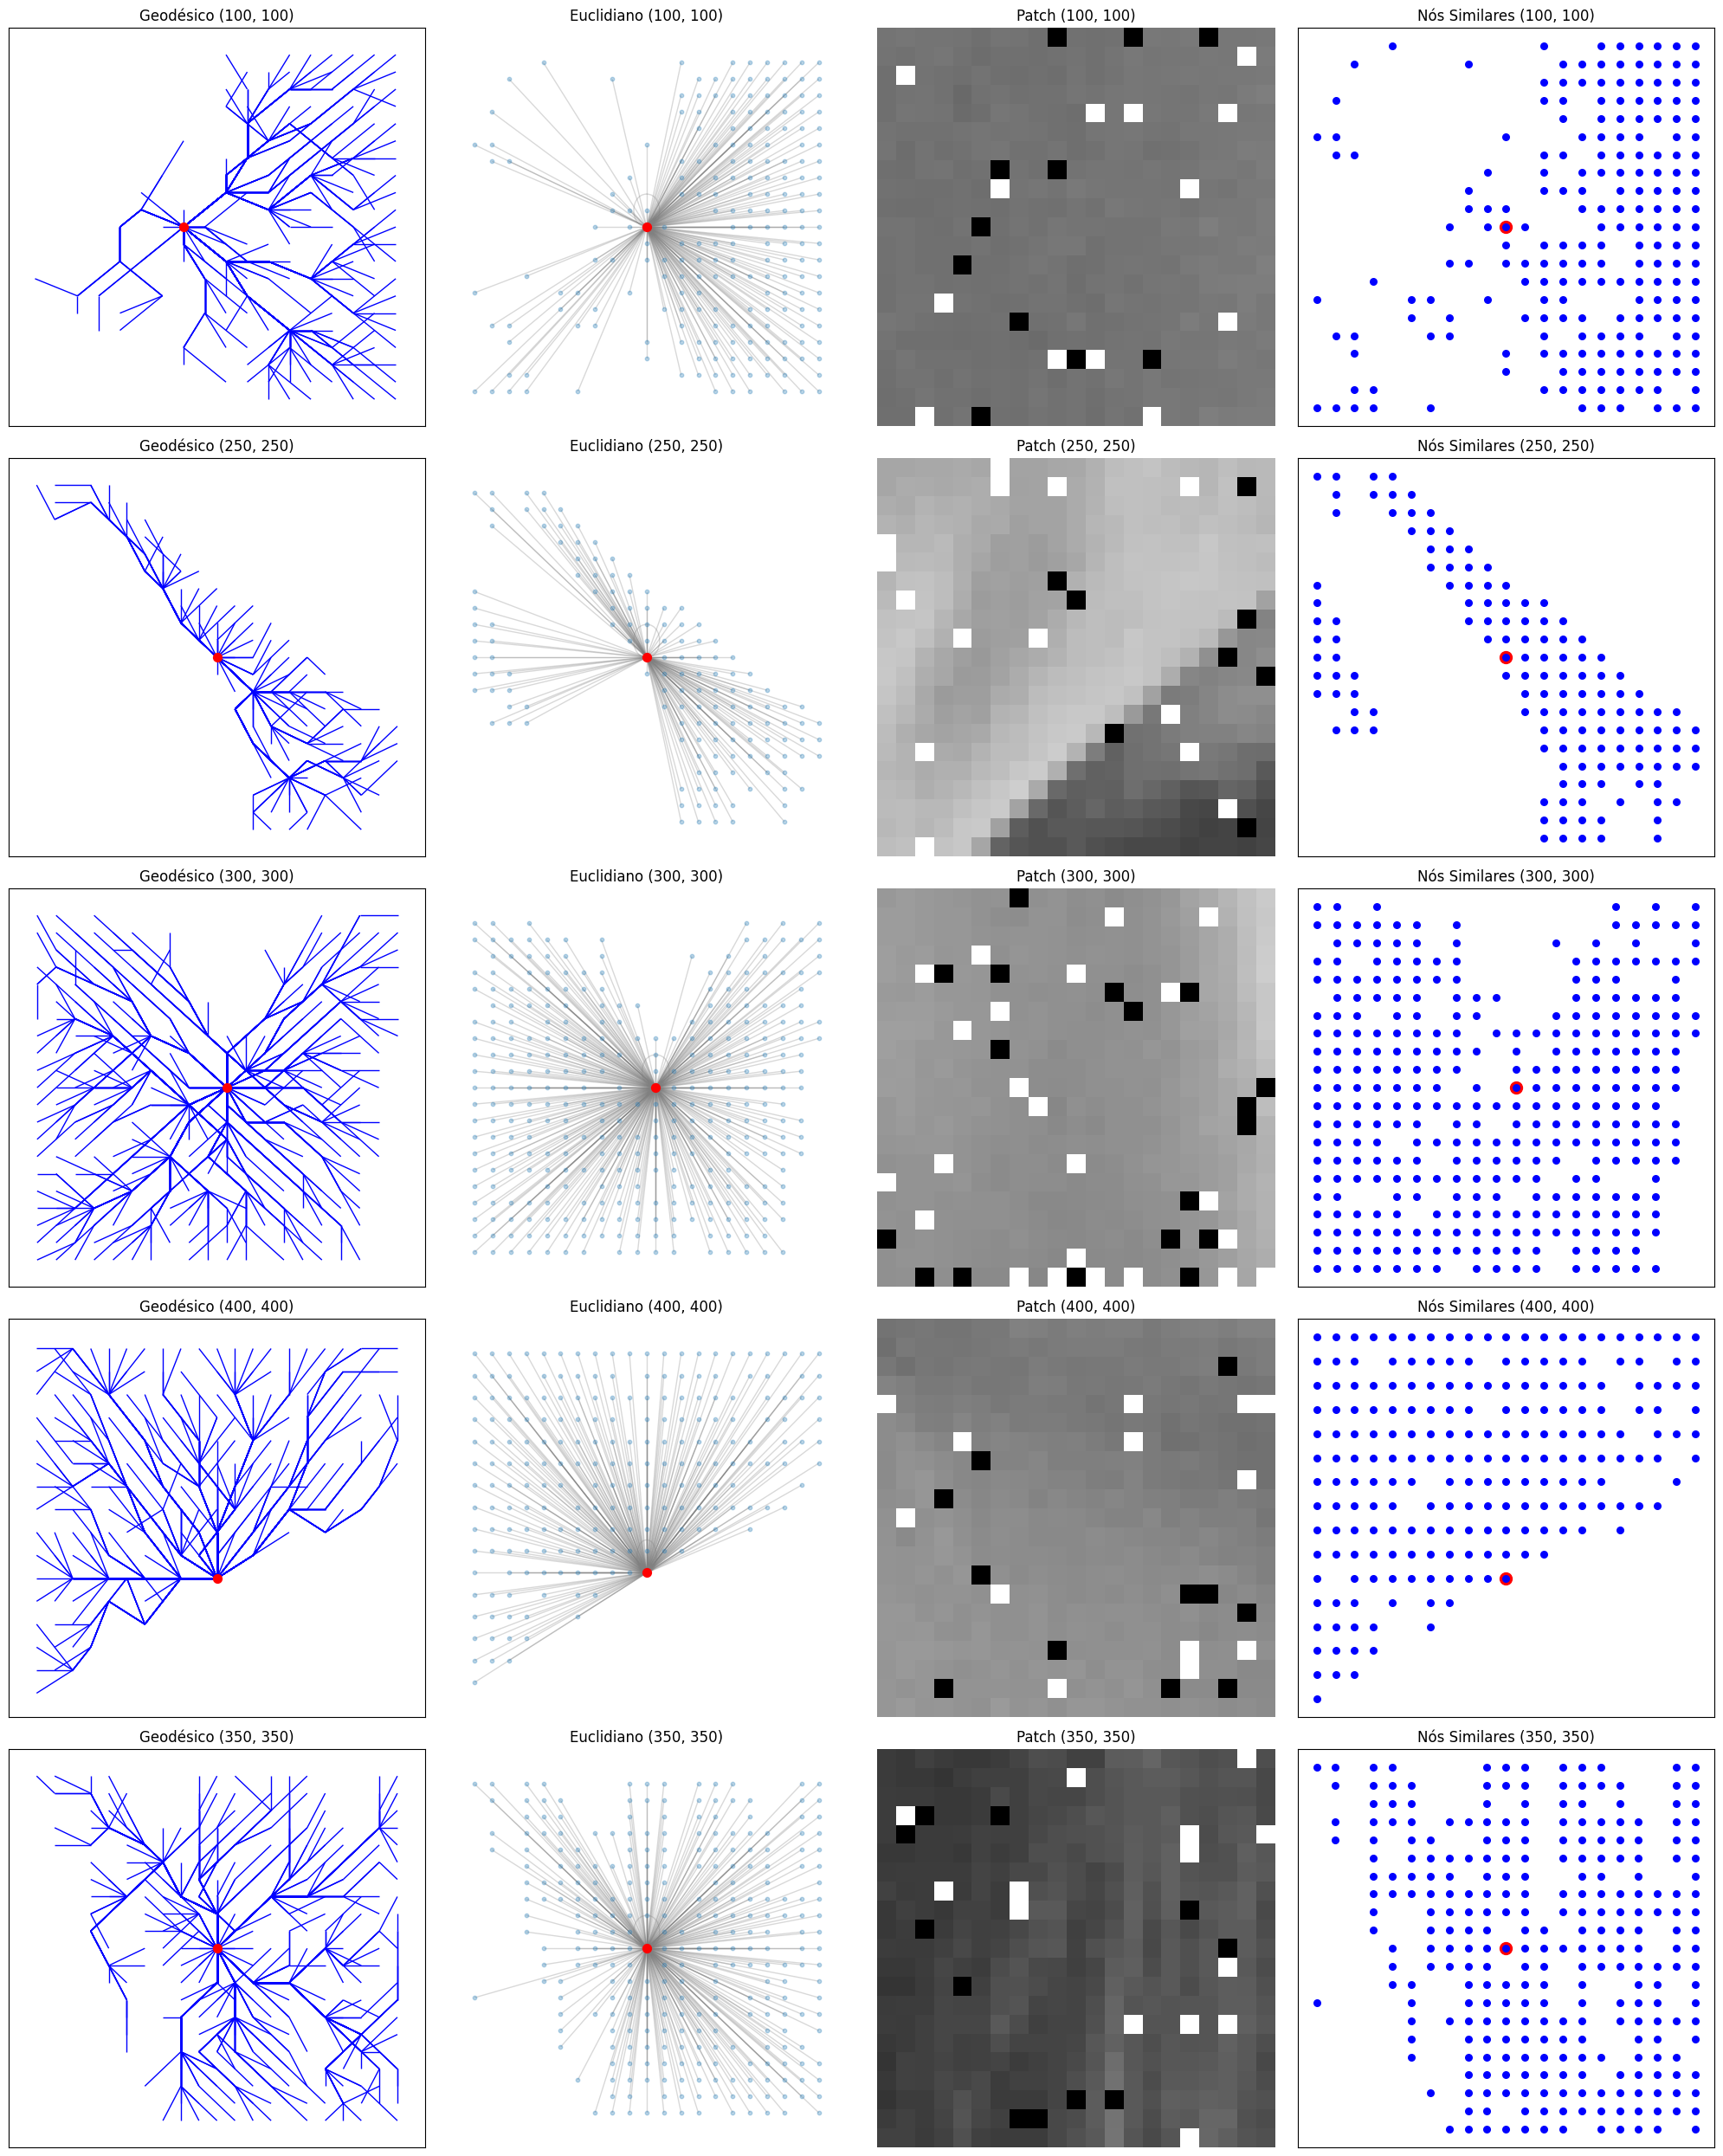

In [23]:
import numpy as np
import networkx as nx
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise

def load_image(path, add_noise=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if add_noise:
        img = random_noise(img, mode='s&p', amount=0.05)  # Adiciona ruído sal e pimenta
        img = (img * 255).astype(np.uint8)
    return img

def build_graph(image, center, patch_size=21, similarity_patch=5, euclidean=False, only_similar=False):
    half = patch_size // 2
    half_similarity = similarity_patch // 2
    x0, y0 = center
    H, W = image.shape
    G = nx.Graph()
    
    similar_pixels = []
    for i in range(max(0, x0 - half), min(H, x0 + half + 1)):
        for j in range(max(0, y0 - half), min(W, y0 + half + 1)):
            if abs(image[i, j] - image[x0, y0]) < 30:  # Critério de similaridade arbitrário
                similar_pixels.append((i, j))
                G.add_node((i, j), intensity=image[i, j])
                
                if not only_similar:
                    for di in range(-half_similarity, half_similarity + 1):
                        for dj in range(-half_similarity, half_similarity + 1):
                            ni, nj = i + di, j + dj
                            if (max(0, x0 - half) <= ni < min(H, x0 + half + 1)) and (max(0, y0 - half) <= nj < min(W, y0 + half + 1)):
                                if abs(image[ni, nj] - image[x0, y0]) < 30:
                                    weight = np.abs(int(image[i, j]) - int(image[ni, nj])) + 1e-5
                                    if euclidean:
                                        G.add_edge((x0, y0), (ni, nj), weight=weight)  # Ligação direta ao pixel central
                                    else:
                                        G.add_edge((i, j), (ni, nj), weight=weight)  # Caminho geodésico
    
    return G, similar_pixels

def visualize_graphs(centers, patch_size, similarity_patch):
    fig, axes = plt.subplots(len(centers), 4, figsize=(20, 5 * len(centers)))
    
    for idx, center in enumerate(centers):
        G_geo, _ = build_graph(image, center, patch_size, similarity_patch, euclidean=False, only_similar=False)  # Mantém o grafo original
        G_euc, _ = build_graph(image, center, patch_size, similarity_patch, euclidean=True, only_similar=False)
        G_sim, similar_pixels = build_graph(image, center, patch_size, similarity_patch, euclidean=False, only_similar=True)
        
        pos_geo = {node: (node[1], node[0]) for node in G_geo.nodes()}
        pos_euc = {node: (node[1], node[0]) for node in G_euc.nodes()}
        pos_sim = {node: (node[1], node[0]) for node in G_sim.nodes()}
        
        shortest_paths = nx.single_source_dijkstra_path(G_geo, center)
        
        ax_geo, ax_euc, ax_patch, ax_nodes = axes[idx]
        nx.draw_networkx_nodes(G_geo, pos_geo, nodelist=[center], node_color='red', node_size=50, ax=ax_geo)
        for target in shortest_paths.keys():
            path_edges = list(zip(shortest_paths[target], shortest_paths[target][1:]))
            nx.draw_networkx_edges(G_geo, pos_geo, edgelist=path_edges, edge_color='blue', width=1, ax=ax_geo)
        ax_geo.set_title(f"Geodésico {center}")
        
        nx.draw(G_euc, pos_euc, node_size=10, edge_color='gray', alpha=0.3, with_labels=False, ax=ax_euc)
        nx.draw_networkx_nodes(G_euc, pos_euc, nodelist=[center], node_color='red', node_size=50, ax=ax_euc)
        ax_euc.set_title(f"Euclidiano {center}")
        
        half = patch_size // 2
        patch = image[center[0] - half:center[0] + half + 1, center[1] - half:center[1] + half + 1]
        ax_patch.imshow(patch, cmap='gray')
        ax_patch.set_title(f"Patch {center}")
        ax_patch.axis("off")
        
        # Exibir apenas os nós dos pixels similares
        nx.draw_networkx_nodes(G_sim, pos_sim, nodelist=[center], node_color='red', node_size=100, ax=ax_nodes)
        nx.draw_networkx_nodes(G_sim, pos_sim, nodelist=similar_pixels, node_color='blue', node_size=30, ax=ax_nodes)
        ax_nodes.set_title(f"Nós Similares {center}")
    
    plt.tight_layout()
    plt.show()

# Carregar imagem
image_path = 'ruidosa/ruidosa_salt_pepper.png'
image = load_image(image_path)

# Definir pixels centrais para visualização dos grafos
centers = [(100, 100), (250, 250), (300, 300), (400, 400), (350, 350)]
visualize_graphs(centers, patch_size=21, similarity_patch=5)
